In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [300]:
import os
import pickle
import operator
import itertools
from collections import defaultdict
import tqdm
import tskit
import numpy as np
import pyslim
import scipy.stats as stats
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.path import Path


from bgspy.tree_utils import load_recrates, load_neutregions
from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.utils import read_centro, BScores
from bgspy.utils import read_bkgd, midpoint, arg_nearest
from bgspy.utils import bin_chrom, get_files, BScores, exact_index
from bgspy.sim_utils import calc_b_from_treeseqs, load_b_chrom_sims 
from bgspy.theory import bgs_segment
from bgspy.classic import BSC16_segment_lazy

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

# from https://writing.stackexchange.com/questions/21658/what-is-the-image-size-in-scientific-paper-if-indicated-as-a-single-1-5-or-2-c 
# in mm
mm_to_inches = lambda x: 0.0393701 * x
img_size = dict(one = mm_to_inches(90), onehalf = mm_to_inches(140), two = mm_to_inches(190))
asp_ratio = dict(golden = (1 + np.sqrt(5))/2, one=1, two=2)
fig_sizes = {(k, ar): np.round((v, v/asp_ratio[ar]), 4) for k, v in img_size.items() for ar in asp_ratio}
fig_sizes

{('one', 'golden'): array([3.5433, 2.1899]),
 ('one', 'one'): array([3.5433, 3.5433]),
 ('one', 'two'): array([3.5433, 1.7717]),
 ('onehalf', 'golden'): array([5.5118, 3.4065]),
 ('onehalf', 'one'): array([5.5118, 5.5118]),
 ('onehalf', 'two'): array([5.5118, 2.7559]),
 ('two', 'golden'): array([7.4803, 4.6231]),
 ('two', 'one'): array([7.4803, 7.4803]),
 ('two', 'two'): array([7.4803, 3.7402])}

In [23]:
force = False

### bgspy B maps

In [224]:
w_grid = np.array([1e-10, 2e-10, 1e-9, 2e-9, 1e-8, 2e-8])
t_grid = np.array([0.0001, 0.00022, 0.00046, 0.001, 0.0022, 0.0046, 0.01, 0.022, 0.046, 0.1])

pkl_b_file = '../data/bmaps/bgspy/B_chr10_all.pkl'

if force or not os.path.exists(pkl_b_file):
    g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
    g.load_annot("../data/annotation/conserved_by_chrom/chr10.bed")
    g.load_recmap("../data/annotation/hapmap/genetic_map_GRCh37_chr10.txt")
    
    m = BGSModel(g, w_grid=w_grid, t_grid=t_grid, split_length=1_000)
    m.calc_Bp(N=1000, step=1_000, ncores=70, nchunks=200)
    m.calc_B(step=1_000, ncores=70, nchunks=70)
    m.save(pkl_b_file)
else:
    m = BGSModel.load(pkl_b_file)

In [338]:
bp = m.BpScores
b = m.BScores

### `calc_bkgd` maps

In [26]:
bkgd_dir = '../data/bmaps/calc_bkgd/'
cached_bkgd1k_file = os.path.join(bkgd_dir, "calc_bkgd_1000.pkl")
mcvb = BScores.load(cached_bkgd1k_file)


In [234]:
sim_B = np.load('../data/slim_sims/chrombgs_chr10/sim_B.npz', allow_pickle=True)

In [286]:
mus = sim_B['mu']
shs = sim_B['sh']

In [287]:
mus, shs

(array([1.e-10, 2.e-10, 1.e-09, 2.e-09, 1.e-08, 2.e-08]),
 array([0.0001 , 0.00022, 0.00046, 0.001  , 0.0022 , 0.0046 , 0.01   ,
        0.022  , 0.046  , 0.1    ]))

In [237]:
simb_pos = (sim_B['pos'][1:] + sim_B['pos'][:-1])/2

In [288]:
sims_means = BScores({'chr10': np.log(sim_B['mean'])}, {'chr10': simb_pos}, mus, shs, step=None)
sims_sds = BScores({'chr10': np.log(sim_B['sd'])}, {'chr10': simb_pos}, mus, shs, step=None)

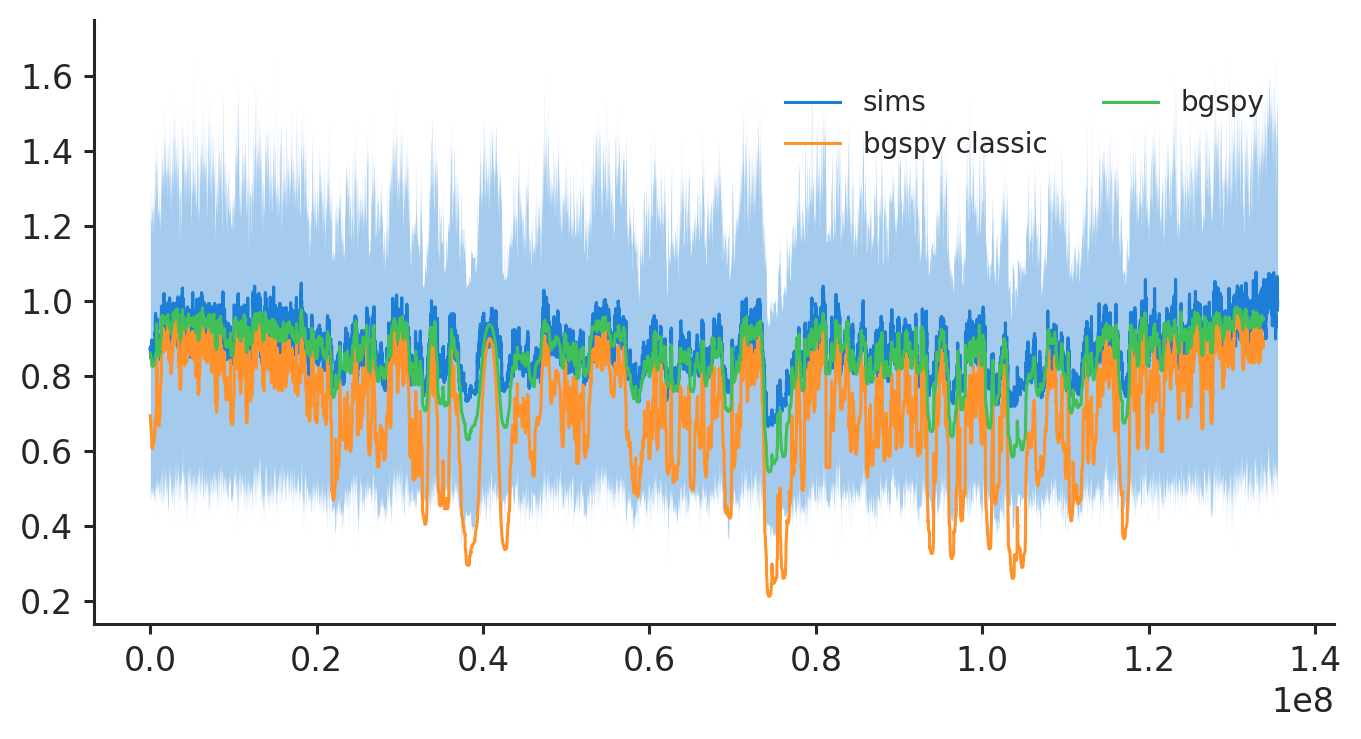

In [340]:
sh = 0.001
mu = 2.e-9


lines = plt.plot(*sims['chr10', mu, sh], label='sims')
sim_pos, sd = sims_sds['chr10', mu, sh]
_, mean = sims_means['chr10', mu, sh]
plt.fill_between(sim_pos, mean - sd, mean + sd, alpha=0.4, 
                 linewidth=0, color=lines[0].get_color())

plt.plot(*b['chr10', mu, sh], label='bgspy classic', zorder=2)
plt.plot(*bp['chr10', mu, sh], label='bgspy')

plt.legend(ncol=2)


In [267]:
def sample_positions(n, genome, chrom):
    g = genome
    pos = np.sort(np.random.randint(0, g.seqlens[chrom], n))
    

building interpolators...		done.
building interpolators...		done.


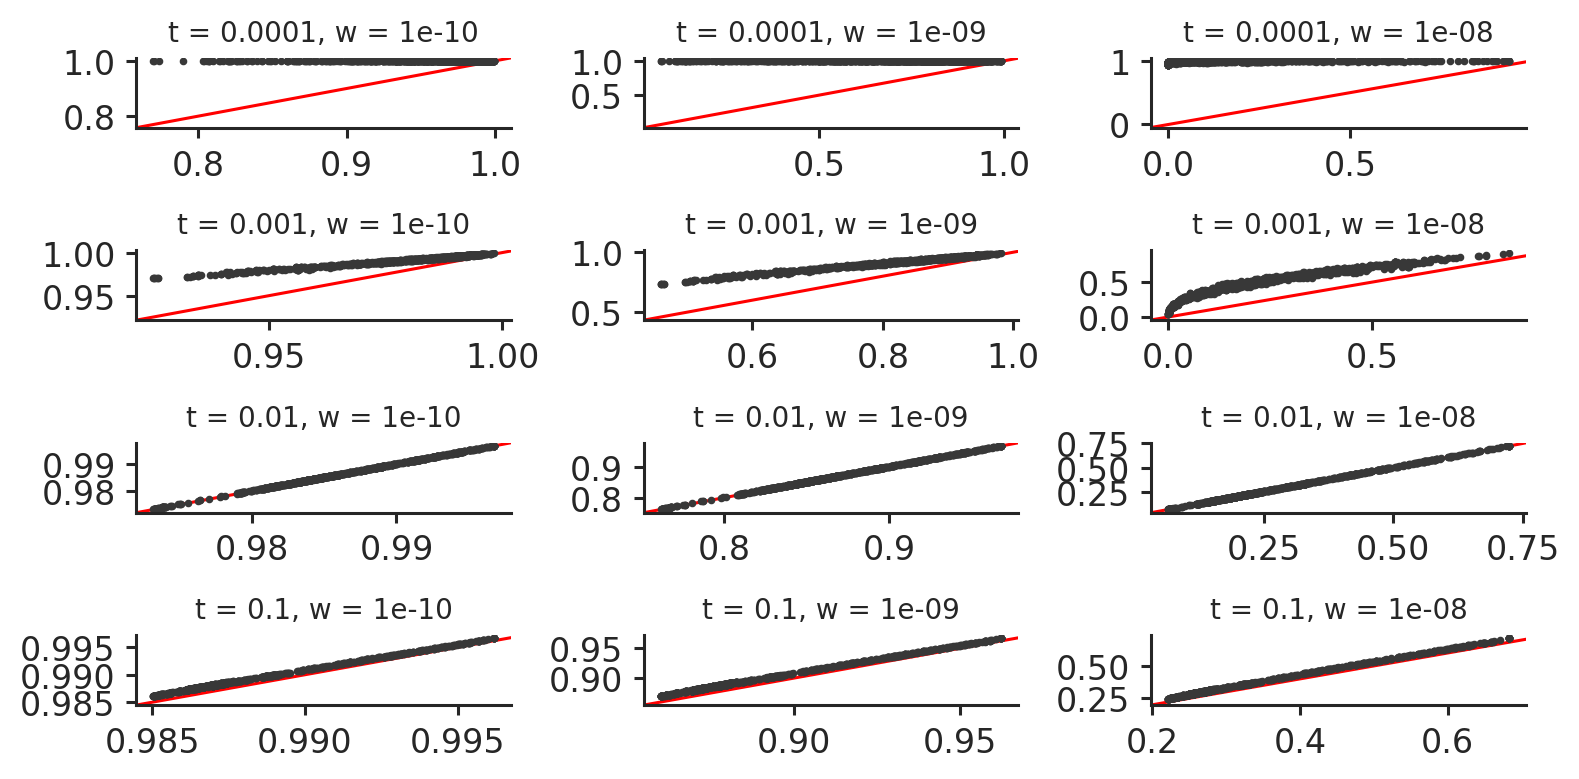

In [341]:
sh = 0.1
mu = 2.e-10

facet_mus = np.array([1.e-10, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
pos = np.random.choice(sim_pos, 1000)

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr)

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    x = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    y = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]

    ax[j, i].scatter(x, y, s=3, c='0.22')
    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='r', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=10)
    
plt.tight_layout()

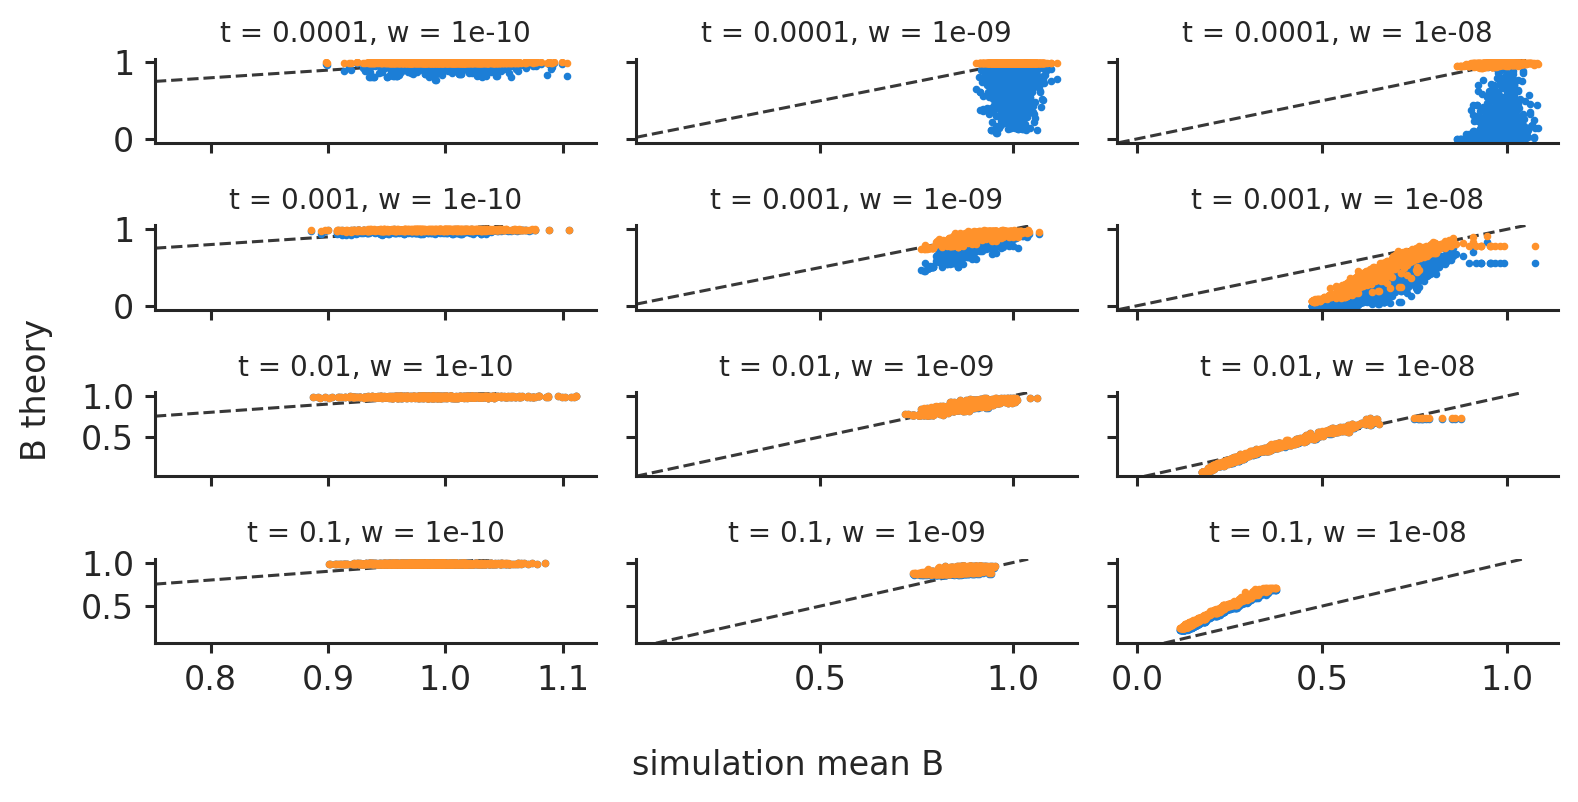

In [357]:
sh = 0.1
mu = 2.e-10

facet_mus = np.array([1.e-10, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
n = 1000
idx = np.random.randint(0, len(sim_pos), n)
pos = sim_pos[idx]

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr, sharex='col', sharey='row')

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    y = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    ya = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    x = sims_means['chr10', mu, sh][1][idx]
    
    ax[j, i].scatter(x, y, s=3)
    ax[j, i].scatter(x, ya, s=3)

    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='0.22', linestyle='dashed', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=10)
    o = 0
    #ax[j, i].set_xlim(o, 1.01)
    #ax[j, i].set_ylim(o, 1.01)
    #if i == 0:
    #    ax[j, i].set_ylabel("B theory")
    #if j == nr:
    #    ax[j, i].set_xlabel("simulation mean B")


f.supxlabel('simulation mean B')
f.supylabel('B theory')

plt.tight_layout()

In [ ]:
len(b['chr10', mu, sh][0])

In [ ]:
f, ax = plt.subplots()
ax.scatter(b['chr10', mu, sh][1], bp['chr10', mu, sh][1])
ax.axline((0.99, 0.99), slope=1, c='0.22')

In [ ]:
sims.keys()

In [ ]:

shs, mus = [set(x) for x in zip(*sims.keys())]

sh = 1e-3
for mu in mus:
    key = (sh, mu)
    try:
        pos, sim_bs = sims[key]
    except:
        continue
    plt.plot(pos[1:], sim_bs.mean(axis=1))



In [ ]:
n = 1000
x = np.repeat(1, n) - np.abs(np.random.normal(0, 1e-8, n))
np.prod(x), np.exp(np.log(x).sum())

In [ ]:
for i, sh in enumerate(b.t):
    plt.plot(b.pos['chr10'], np.exp(b.B['chr10'][:, 1, i]), label=sh)

In [ ]:
dnnb.t, dnnb.w

In [ ]:
arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t)

In [ ]:
mu = 1e-8
sh = 0.1
for i in [0] + list(range(5, dnnb.B['chr10'].shape[3])):
    ls = 'solid' if i > 0 else 'dashed'
    plt.plot(dnnb.pos['chr10'], dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, i], label=i, linestyle=ls)

#plt.plot(dnnb.pos['chr10'], dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, 0], label='predict B')
#plt.plot(b.pos['chr10'], np.exp(b.B['chr10'][:, arg_nearest(mu, b.w), arg_nearest(sh, b.t)]), label='bgspy')

pos, sim_bs = sims[(sh, mu)]
plt.plot(pos[1:], sim_bs.mean(axis=1), label='sims', c='k')

plt.legend(loc='upper center', ncol=3)
#plt.semilogy()
#plt.ylim(0, 1)

In [ ]:
mu = 1e-8
sh = 0.0001
for i in range(dnnb.B['chr10'].shape[3]):
    ls = 'solid' if i > 0 else 'dashed'
    plt.plot(dnnb.pos['chr10'], dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, i], label=i, linestyle=ls)

#plt.plot(dnnb.pos['chr10'], dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, 0], label='predict B')
#plt.plot(b.pos['chr10'], np.exp(b.B['chr10'][:, arg_nearest(mu, b.w), arg_nearest(sh, b.t)]), label='bgspy')

pos, sim_bs = sims[(sh, mu)]
plt.plot(pos[1:], sim_bs.mean(axis=1), label='sims', c='k')

plt.legend(loc='upper center', ncol=3)
#plt.ylim(0, 1)

In [ ]:
cc = np.load('../data/dnnb/preds/chr10/hg38_chr10_7920_206512_229263.npy')

In [ ]:
cc.shape

In [ ]:
for i in range(4):
    plt.plot(cc[1, 4, :, i])

In [ ]:
(0.95 - 0.97)/0.97

In [ ]:
dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :10, :]

In [ ]:
plt.scatter(dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, 3],  
            dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, 4])
plt.axline((0, 0), slope=1, c='k')

In [ ]:
dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, 2]

In [ ]:
plt.scatter(dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, 2],  
            dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), :, 1])
plt.axline((0, 0), slope=1, c='k')

In [ ]:
plt.plot(dnnb.B['chr10'][0, 3, :, 1])

In [ ]:
import itertools

In [ ]:
mu, sh, dnnb.w[0], dnnb.t[3]

In [ ]:
mu, sh = 1e-8, 0.001

idx = np.random.randint(0, dnnb.B['chr10'].shape[2], 100)

nmodels = dnnb.B['chr10'].shape[3]
print(list(itertools.product(range(nmodels), range(nmodels))))


for (i, j) in itertools.product(range(nmodels), range(nmodels)):
    if i == j:
        continue
    plt.scatter(dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), idx, i],  
                dnnb.B['chr10'][arg_nearest(mu, dnnb.w), arg_nearest(sh, dnnb.t), idx, j])
plt.axline((0, 0), slope=1, c='k')

In [ ]:
b = LearnedB(dnnb.w, dnnb.t)

In [ ]:
b.load_func('../data/slim_sims/bmap_hg38/fits/bmap_hg38_reps_0n128_0n64_0n32_0n8_2nx_eluactiv_fit_1rep')

In [ ]:
Xp = np.load('../data/dnnb/xps/chr10/hg38_chr10_954_109476_147131.npy')

In [ ]:
a = b.func.predict(Xp)

In [ ]:
b = b.func.predict(Xp)

In [ ]:
b

In [ ]:
plt.scatter(a, b)
plt.axline((0.94, 0.94), slope=1)

In [ ]:
ti = 2
mu = 1e-9

#plt.plot(b.pos['chr10'], np.exp(b.B['chr10'][:, 1, ti]), c='k')

fig, ax = plt.subplots(ncols=2, nrows=2)

cells = list(itertools.product(range(2), range(2)))

for ti in range(4):
    sh = dnnb.t[ti]
    sim_d = sims.get((sh, mu))
    for i in range(1, 4):
        ax[cells[ti]].plot(dnnb.pos['chr10'], dnnb.B['chr10'][1, ti, :, i], label=i)
        ax[cells[ti]].set_title(f"t = {dnnb.t[ti]}")
        ax[cells[ti]].set_ylabel('B')
        ax[cells[ti]].set_xlabel('position')
        if sim_d is not None and len(sim_d):
            pos, sim_bs = sim_d
            ax[cells[ti]].plot(pos[1:], sim_bs.mean(axis=1), label='sims', c='k', alpha=0.3, zorder=-5)
    ax[cells[ti]].plot(b.pos['chr10'], np.exp(b.B['chr10'][:, 1, arg_nearest(sh, b.t)]), alpha=0.3, c='r')

plt.legend()
plt.tight_layout()

In [ ]:
np.random.exponential([1, 100, 2, 1000], 4)

In [ ]:
with np.printoptions(precision=4):
    print(Xp[np.random.randint(0, Xp.shape[0], 30), :])

In [ ]:
bgs_segment(1e-8, 0.1, 1000, 1e-8, 1e-9)

In [ ]:
list(enumerate('abcdef', 1))


In [ ]:
plt.plot(mcvb.pos['chr10'], mcvb.B['chr10'][:, 0, 3], label='calc_bkgd')
plt.plot(b.pos['chr10'], np.exp(b.B['chr10'][:, 1, 1]), label='bgspy')
plt.plot(dnnb.pos['chr10'], dnnb.B['chr10'][1, 2, :, 2], label='dnn b')
plt.plot(pos[1:], sim_bs.mean(axis=1), label='sims')
plt.legend(ncol=2)


In [ ]:
pos, sim_bs = sims[(('sh', 0.001), ('mu', 1e-08))]

plt.plot(mcvb.pos['chr10'], mcvb.B['chr10'][:, 0, 2])
plt.plot(b.pos['chr10'], 10**b.B['chr10'][:, 2, 2])
plt.plot(dnnb.pos['chr10'], 10**dnnb.B['chr10'][1, 1, :])
plt.plot(pos[1:], sim_bs.mean(axis=1))
plt.ylim(0, 1)

In [ ]:
dnnb.w, dnnb.t

### Simulation Results

In [ ]:
np.diff(m.segments.ranges, axis=1)

In [ ]:
with open('../slim_sims/bgs/chr10_B_sims.pkl', 'rb') as f:
    sims = pickle.load(f)

In [ ]:
sims.keys()

In [ ]:
cached_bgsmap_file = '../data/bmaps/bgsmap_sims.pkl'
with open(cached_bgsmap_file, 'wb') as f:
    pickle.dump(sims, f)  

In [ ]:
cached_bgsmap_file = '../data/bmaps/bgsmap_sims.pkl'

force = False

if force or not os.path.exists(cached_bgsmap_file):
    sims = load_b_chrom_sims(DATADIR)
    with open(cached_bgsmap_file, 'wb') as f:
        pickle.dump(sims, f)
else:
    with open(cached_bgsmap_file, 'rb') as f:
        sims = pickle.load(f)    

In [ ]:
i = np.zeros(g.seqlens['chr10'])
for row in m.segments.ranges:
    i[slice(*row)] = 1

covered_bases = np.where(i)[0]
wins = np.linspace(0, g.seqlens['chr10'], g.seqlens['chr10'] // 100_000).astype(int)
coverage = stats.binned_statistic(covered_bases, np.full(len(covered_bases), 1), statistic=np.sum, bins=wins)

### Load DNNB

In [ ]:
dnnb = LearnedB.load_predictions(g, '../data/dnnb')

In [ ]:
dnnb.w, dnnb.t, dnnb.B['chr10'].shape

In [ ]:
plt.plot(dnnb.pos['chr10'], 10**dnnb.B['chr10'][1, 1, :])

In [ ]:
fig, ax = plt.subplots()

line = ax.plot(pos, bmean, label="simulations", linewidth=lw, zorder=20)
print(m.w[arg_nearest(mu, m.w)], m.t[arg_nearest(s, m.t)])
bgspy_b = m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]
line = ax.plot(m.BScores.pos['chr10'], 10**(bgspy_b), label="bgspy", linewidth=lw, zorder=5)

In [ ]:
s, mu = 0.01, 1e-8
pos_all, b_all = sims[(('sh', s), ('mu', mu))]

bvar = b_all.var(axis=1)
bmean = b_all.mean(axis=1)

max_pos = np.max(m.BScores.pos['chr10'])

pos, bmean, bvar = pos_all[pos_all < max_pos], bmean[midpoint(pos_all) < max_pos], bvar[midpoint(pos_all) < max_pos], 

## main plot
gridkw =  {"height_ratios": [5, 0.2, 0.2], "hspace": 0}
fig, (ax, gene_ax, rec_ax) = plt.subplots(ncols=1, nrows=3, gridspec_kw=gridkw, sharex=True)
fig.set_size_inches(*fig_sizes['two', 'two'])
lw = 1
line = ax.plot(pos, bmean, label="simulations", linewidth=lw, zorder=20)
print(m.w[arg_nearest(mu, m.w)], m.t[arg_nearest(s, m.t)])
bgspy_b = m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]
line = ax.plot(m.BScores.pos['chr10'], np.exp(bgspy_b), label="bgspy", linewidth=lw, zorder=5)
line = ax.plot(bkgd[s/2]['chr10'][0], bkgd[s/2]['chr10'][1], label="calc_bkgd", linewidth=lw)

# B intervals
lower, upper = bmean + np.sqrt(bvar), bmean - np.sqrt(bvar)
lower2, upper2 = bmean + 2*np.sqrt(bvar), bmean - 2*np.sqrt(bvar)
rec_sigma = 1.75e2
smooth_lower = gaussian_filter1d(lower, rec_sigma)
smooth_upper = gaussian_filter1d(upper, rec_sigma)
ribbon = ax.fill_between(pos, smooth_lower, smooth_upper, interpolate=True, alpha=0.2)

leg = ax.legend(loc=(0.7, 0.7), fontsize=9)
for lh in leg.legendHandles:
    lh.set_linewidth(2)

ax.set_xticklabels([])
ax.tick_params(bottom=False)  
ax.set_ylabel('B')
#ax.set_ylim(0, 0.8)
ax.yaxis.set_major_formatter(lambda x, pos: f"{int(np.round(100*x))}%")
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_position(('outward', 6.6))

n = 10
bar_height = 1
axis_pad = bar_height
ends, rates = m.recmap.rates['chr10']
ends, rates = ends[ends < max_pos], rates[ends < max_pos]
rates[0] = 0
rate_min = 0 # np.quantile(rates, 0.1)
rate_max = 3e-8 # np.quantile(rates, 0.9)
norm = plt.Normalize(rate_min, rate_max)
smooth_rates = gaussian_filter1d(rates, 300)
rec_cbar = rec_ax.pcolormesh(ends, np.arange(n), np.repeat(smooth_rates[:, None], n, axis=1).T, norm=norm)
rec_ax.set_yticks([])
rec_ax.set_xticks(np.arange(0, 1.4e8+1, 20_000_000))
rec_ax.set_xticklabels(np.arange(0, 1.4e8+1, 20_000_000)/1e8)
rec_ax.set_xlabel('position')
rec_ax.tick_params(left=False) 
rec_ax.spines['left'].set_visible(False)

# gene density
ends, density = coverage.bin_edges, 100*coverage.statistic/(coverage.bin_edges[1:] - coverage.bin_edges[:-1])
norm = plt.Normalize(density.min(), density.max())
smooth_rates = gaussian_filter1d(density, 1)
gene_cbar = gene_ax.pcolormesh(ends[:-1], np.arange(n), np.repeat(smooth_rates[:, None], n, axis=1).T, norm=norm, cmap='plasma')
gene_ax.axis('off')
offset = 0.04

# color bar axes
width = 0.015
start = 0.925
cax2 = fig.add_axes([offset+start+width, 0.35, width, 0.4])
cax1 = fig.add_axes([offset+start, 0.35, width, 0.4])
cbar1 = fig.colorbar(rec_cbar, cax=cax1)
cbar2 = fig.colorbar(gene_cbar, cax=cax2)
cax1.yaxis.set_ticks_position('left')
cax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
cax1.set_yticks(np.array([0, 1e-8, 2e-8, 3e-8]))
cax1.set_yticklabels(np.array([0, 1, 2, 3]))
cax1.yaxis.set_label_position('left')
cax1.set_ylabel('recomb (cM/Mb)', fontsize=10)
#cax1.yaxis.set_label_position('left')
cax2.set_ylabel('conserved density', fontsize=10, rotation=-90)
cax1.tick_params(labelsize=8)
cax2.tick_params(labelsize=8)
cbar1.outline.set_linewidth(1)
#cbar1.outline.set_visible(False)
#cbar2.outline.set_visible(False)
cbar2.outline.set_linewidth(1) 
cax1.yaxis.set_tick_params(width=1)
cax2.yaxis.set_tick_params(width=1)

def centro_notch(ax, coords, seqlen, c=2.5, lw=1, lc='0.22', flip=False):
    ymin, ymax = ax.get_ylim()
    m = 1/c if not flip else 1-1/c
    ymid = (ymin + ymax)*m
    if flip:
        ymin, ymax = ymax, ymin
    start, cent, end = coords
    verts = [(start, ymax*1.1), (cent, ymid), (end, ymax*1.1)]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO]
    centro_verts = mpath.Path(verts, codes)
    centro_marker = patches.PathPatch(centro_verts, facecolor='white', lw=0)
    ax.add_patch(centro_marker)
    ax.plot([0, 0, start, cent, end, seqlen, seqlen], [ymin, ymax, ymax, ymid, ymax, ymax, ymin], c=lc, linewidth=lw)
    
#centro_notch(gene_ax, centro['chr10'], seqlen=seqlens['chr10'])
#centro_notch(rec_ax, centro['chr10'],  seqlen=seqlens['chr10'], flip=True)
rec_ax.spines['bottom'].set_position(('outward', 4))


In [ ]:
bins = bin_chrom(g.seqlens['chr10'], 1e6)

sim_x, sim_y = pos, bmean
mcv_x, mcv_y = bkgd[s/2]['chr10'][0], bkgd[s/2]['chr10'][1]

In [ ]:
np.nanmean((stats.binned_statistic(mcv_x, mcv_y, bins=bins).statistic - stats.binned_statistic(sim_x, sim_y, bins=bins).statistic)**2)

In [ ]:
plt.plot(stats.binned_statistic(sim_x, sim_y, bins=bins, statistic=np.nanmean).bin_edges[1:], (stats.binned_statistic(sim_x, sim_y, bins=bins, statistic=np.nanmean).statistic - stats.binned_statistic(mcv_x, mcv_y, bins=bins, statistic=np.nanmean).statistic)**2)

In [ ]:
m = np.arange(100).reshape((25, 4))
#m + np.arange(25)[:, None]
m + np.arange(4)

In [ ]:
ribbon.get_facecolor()

Bias by recombination?

In [ ]:
np.repeat(rates[:, None], 100, axis=1).shape

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
binterpols = m.BScores_interpolater(0)

In [ ]:
fig = plt.figure()

fig, ax = plt.subplots(ncols = 2)
fig.set_size_inches(*fig_sizes['two', 'one'])
x = bmean
y = np.exp(binterpols['chr10'][(1e-8, 1e-2)](midpoint(pos)))
bkgd_y = bkgd[s/2]['chr10'][1]
bkgd_func = interpolate.interp1d(bkgd[s/2]['chr10'][0], bkgd_y, fill_value=(bkgd_y[0], bkgd_y[-1]), bounds_error=False, kind='quadratic')
z = bkgd_func(midpoint(pos))

def corr(x, y, digits=2):
    return np.round(np.corrcoef(x, y)[0, 1], digits)

mae = lambda x, y: np.round(MAE(x, y), 2)

sc0 = ax[0].scatter(x, z, s=5, alpha=0.4, label='calc_bkgd', linewidth=0)
sc1 = ax[0].scatter(x, y, s=5, alpha=0.4, label='bgspy', linewidth=0)
ax[0].text(0.45, 0.1, f"$R^2 = {corr(x, z)}, MAE = {mae(x, z)}$", c=sc0.get_facecolors()[0], alpha=1, size=8)
ax[0].text(0.45, 0.05, f"$R^2 = {corr(x, y)}, MAE = {mae(x, y)}$", c=sc1.get_facecolors()[0], alpha=1, size=8)
ax[0].axline((0.1, 0.1), slope=1, c='#e03131', linestyle='dashed')
ax[0].set_xlabel("$\mathrm{E}(B)$ from simulations")
ax[0].set_ylabel("B Scores")
ax[0].set_aspect('equal', 'box')
ax[0].set_yticks(np.linspace(0, 0.8, 5))
ax[0].set_xlim((0, 0.8))
ax[0].set_ylim((0, 0.8))
leg = ax[0].legend(loc=(-0.05, 0.7))
for lh in leg.legendHandles:
    lh.set_alpha(1)
    lh.set_sizes([50] * len(lh.get_sizes()))

#ax[1].scatter(z, y, s=4, c=(x-z)/x, cmap='brg')
ax[1].scatter(z, y, s=5, c='0.22', alpha=0.1, linewidth=0)
ax[1].text(0.55, 0.05, f"$R^2 = {np.round(np.corrcoef(z, y)[0, 1], 2)}$")
ax[1].axline((0, 0), slope=1, c='#e03131', linestyle='dashed')
ax[1].set_xlabel("calc_bkgd")
ax[1].set_ylabel("bgspy")
ax[1].set_yticks(np.linspace(0, 0.8, 5))
ax[1].set_xlim((0, 0.8))
ax[1].set_ylim((0, 0.8))
ax[1].set_aspect('equal', 'box')
plt.tight_layout()

In [ ]:
plt.plot(midpoint(coverage.bin_edges), coverage.statistic/100_000)

In [ ]:
s, mu = 2e-3, 1e-8
pos, b = sims[(('s', s), ('mu', mu))]

fig, ax = plt.subplots()
ax.plot(midpoint(pos), b.mean(axis=1), label="sims")
bgspy_b = m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]
ax.plot(m.BScores.pos['chr10'], np.exp(bgspy_b), label="bgspy")
ax.plot(bkgd[s/2]['chr10'][0], bkgd[s/2]['chr10'][1], label="calc_bkgd")
ax.legend(loc='lower left')
#ax.axvline(0.375e8, c='red')
#ax.axvline(0.43e8, c='red')

ax.set_xlabel('position')
ax.set_ylabel('B')